In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd

In [2]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/7classes_data/"
SELECTED_CLASS = "10000_TB_Class.csv"
SELECTED_LABEL = "Is_TB"
SUB = 'TB'
LABEL="TB_"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob(SUB+'/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + SUB + "/train/"
VALID_PATH = PATH + SUB + "/valid/"
TEST_PATH = PATH + SUB + "/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
#Load pre-trained InceptionV3 MODEL
myInception = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4",
                            trainable = False)
myModel = tf.keras.Sequential([
    myInception,
    layers.Dropout(0.4),
    layers.Dense(1024,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
myModel.build([None,224,224,3])

In [5]:
#myModel.summary()

In [6]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=30,verbose=1)
myCheckpoint = ModelCheckpoint('Model/'+LABEL+'IncpV3.hdf5',
                               monitor='val_loss',
                              save_best_only=True)
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [7]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-4)
                ,metrics=['accuracy',metrics.Precision(),metrics.Recall()])

In [8]:
TRAIN_IMG = 8000
TEST_IMG = 1000
VALID_IMG = 1000

In [9]:
#Training myModel
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
VALID_STEP = np.ceil(VALID_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 100,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = VALID_STEP,
                               verbose = 2,
                               callbacks=[myCheckpoint,myStop])

myModel.save('Model/'+LABEL+'Incep3_done.h5')

Train for 250.0 steps, validate for 32.0 steps
Epoch 1/100
250/250 - 31s - loss: 0.6347 - accuracy: 0.7475 - precision: 0.1808 - recall: 0.1744 - val_loss: 0.5015 - val_accuracy: 0.8290 - val_precision: 0.2083 - val_recall: 0.0318
Epoch 2/100
250/250 - 21s - loss: 0.5642 - accuracy: 0.7996 - precision: 0.2185 - recall: 0.1096 - val_loss: 0.4839 - val_accuracy: 0.8320 - val_precision: 0.2381 - val_recall: 0.0318
Epoch 3/100
250/250 - 21s - loss: 0.5621 - accuracy: 0.7979 - precision: 0.1906 - recall: 0.0904 - val_loss: 0.4722 - val_accuracy: 0.8310 - val_precision: 0.2273 - val_recall: 0.0318
Epoch 4/100
250/250 - 21s - loss: 0.5474 - accuracy: 0.8009 - precision: 0.1899 - recall: 0.0840 - val_loss: 0.4649 - val_accuracy: 0.8360 - val_precision: 0.2308 - val_recall: 0.0191
Epoch 5/100
250/250 - 21s - loss: 0.5433 - accuracy: 0.8055 - precision: 0.2080 - recall: 0.0872 - val_loss: 0.4581 - val_accuracy: 0.8360 - val_precision: 0.2308 - val_recall: 0.0191
Epoch 6/100
250/250 - 21s - loss:

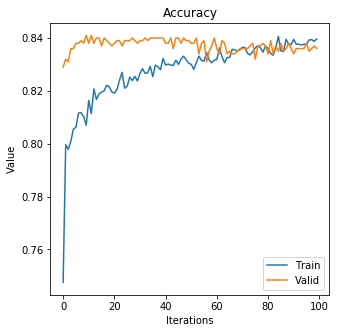

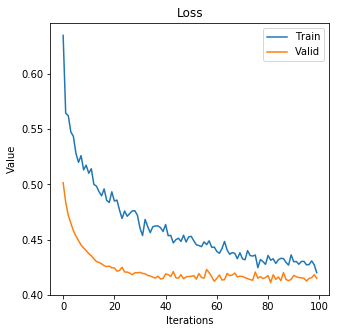

In [10]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"InceptV3_Acc.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig('Run_Result/'+LABEL+"InceptV3_Loss.png")
plt.show()